##  Importing Dependencies
  

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import random
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.14.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#  Dataset Loading


In [ ]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text'] #rename the columns for our reference
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1) #drop useless columns
#We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [ ]:
df= df.drop_duplicates() #check for duplicate

In [ ]:
lab_to_sentiment = {0:"Negative", 4:"Positive"} # maps numerical labels (0 and 4) to sentiment labels ("Negative" and "Positive").
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

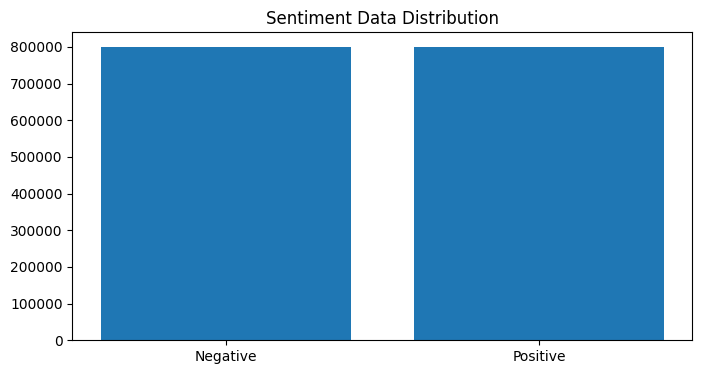

In [ ]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [ ]:
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
681765,Negative,ay TINATAMAD MAG POST NG PICS SA SHANGHAI! ht...
1075597,Positive,@SQUASCHOOM @itskrystalskye ME TOOO YUMMMM
213833,Negative,Giving away my sister at her wedding...can I g...
245370,Negative,up and doing some hw.
187787,Negative,@latinoboi1988 wooooh! that's crazy...but it ...
593887,Negative,"I did all I could,and I gave everything but yo..."
21985,Negative,Gotta send my monitor back to Samsung. Can a...
636364,Negative,Trying to get off the bed I feel lazy today!
516908,Negative,Watching TZP makes me wanna go home to Mummy a...
684341,Negative,Ugh i wish i wouldnt of slept the day away i ...


# Text Preprocessing


Stemming/ Lematization
-Hyperlinks and Mentions
-Stopwords


In [ ]:
stop_words = stopwords.words('english') #stop words
stemmer = SnowballStemmer('english') #stemminzation
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+" #hyperlink

In [ ]:
def preprocess(text, stem=False):
  # Clean the text using the defined regular expression and convert to lowercase
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()

  # Initialize an empty list to store tokens
  tokens = []

  # Split the cleaned text into tokens and process each token
  for token in text.split():
    # Check if the token is not in the list of stop words
    if token not in stop_words:
      # If stem is True, apply stemming using the Snowball Stemmer
      if stem:
        tokens.append(stemmer.stem(token))
      # If stem is False, add the token as it is
      else:
        tokens.append(token)

  # Join the tokens into a cleaned and processed text
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x)) #apply preprocessing on text

### Positive Words

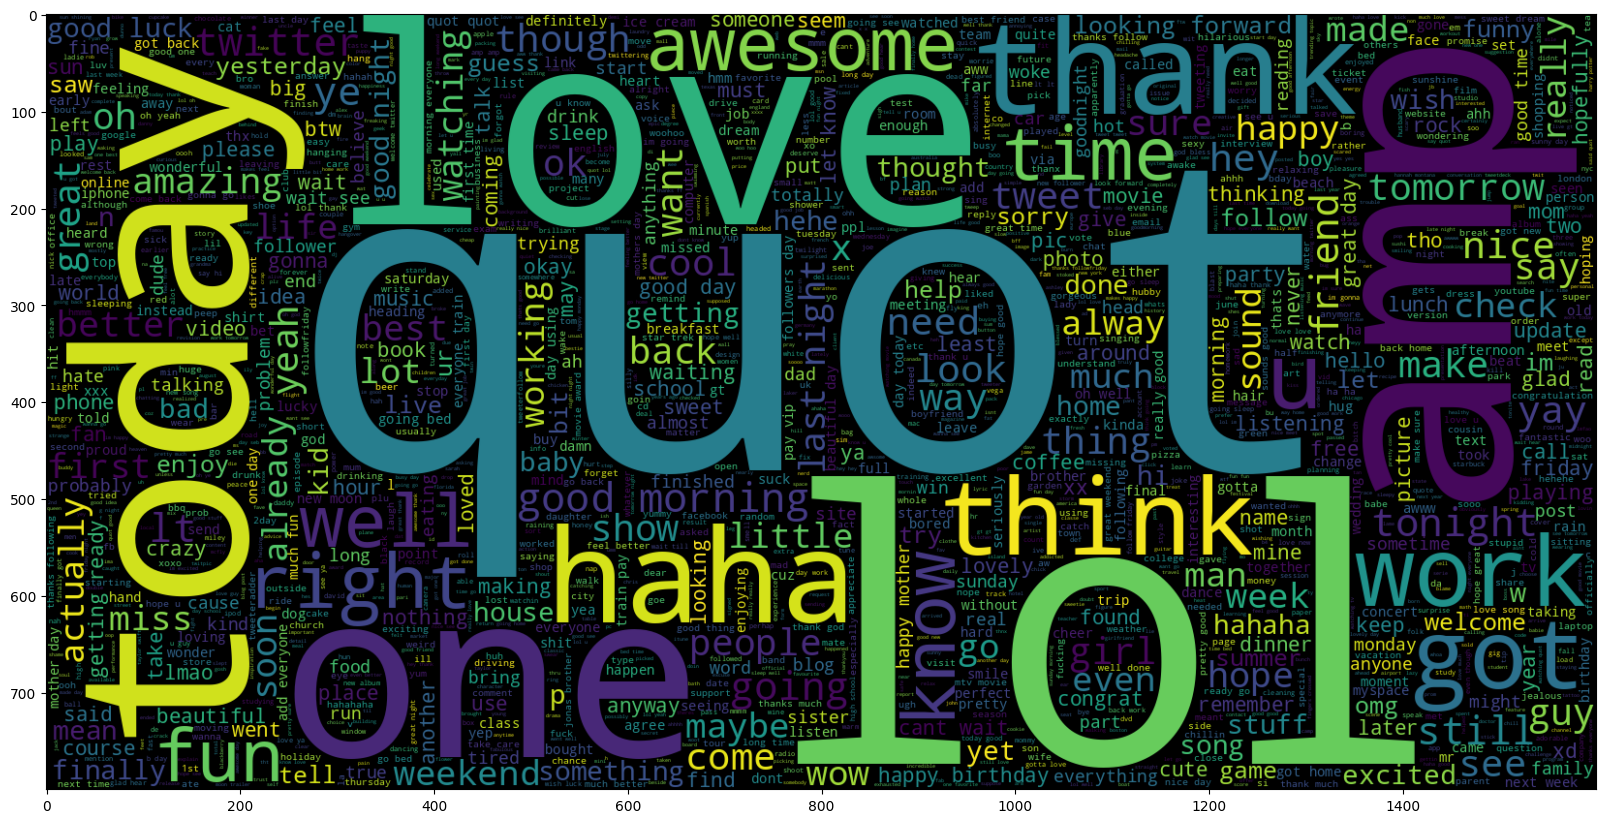

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

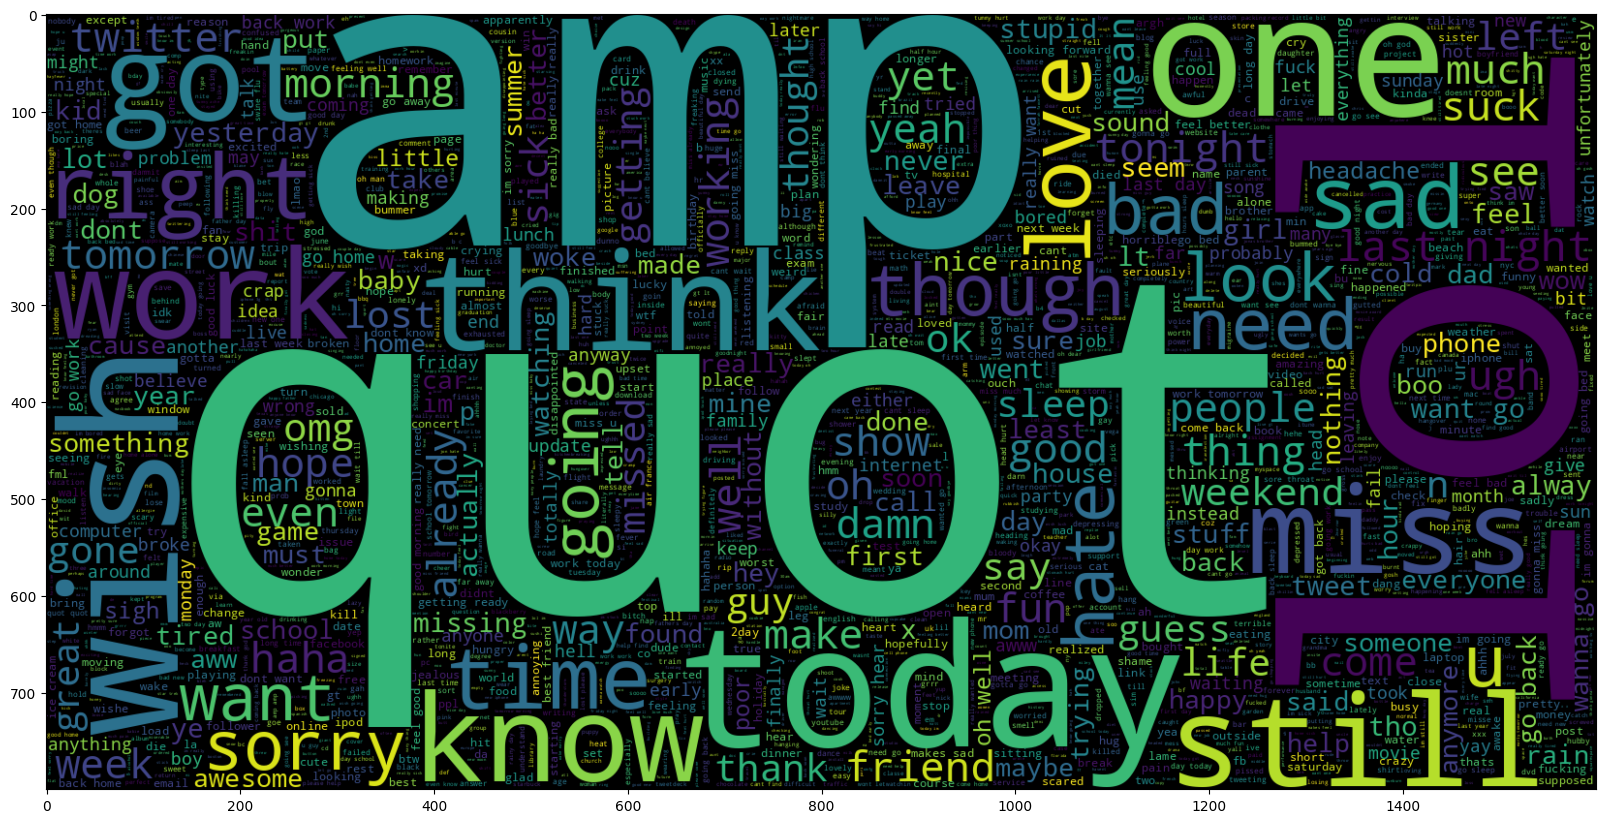

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000 #the maximum number of unique words or tokens considered in the entire dataset
MAX_SEQUENCE_LENGTH = 30 # the maximum length of a sequence

In [ ]:
# Split into training and remaining data (for validation and test)
train_data, remaining_data = train_test_split(df, test_size=1 - TRAIN_SIZE, random_state=7)

# Further split the remaining data into validation and test sets
val, test_data = train_test_split(remaining_data, test_size=0.5, random_state=7)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [ ]:
train_data.head(10) #print first 10 rows

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


# Tokenization

In [ ]:
tokenizer = Tokenizer() #create tokens for every word in the data corpus and map them to a index using dictionary.
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index #contains the index for each word
vocab_size = len(tokenizer.word_index) + 1 #represents the total number of word in the data corpus
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [ ]:
# Tokenize and pad sequences for training data
"""It takes a list of texts and converts each text into a sequence of integers.
Each unique word in the text is replaced by its corresponding integer index based on the vocabulary learned by the tokenizer during training.
"""
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen=MAX_SEQUENCE_LENGTH)#to ensure that they all have the same length


# Tokenize and pad sequences for testing data
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen=MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(tokenizer.texts_to_sequences(val.text),
                       maxlen=MAX_SEQUENCE_LENGTH)

# Display the shape of the training data
print("Training X Shape:", x_train.shape)

# Display the shape of the testing data
print("Testing X Shape:", x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [ ]:
labels = train_data.sentiment.unique().tolist()# is used to extract unique values from the 'sentiment' column in the train_data DataFrame and convert them into a list.

### Label Encoding

In [ ]:
# Create a LabelEncoder instance
encoder = LabelEncoder()

# Fit the encoder on the sentiment labels in the training data
encoder.fit(train_data.sentiment.to_list())

# Transform the sentiment labels in the training and testing data to numerical values
y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())
y_val = encoder.transform(val.sentiment.to_list())


# Reshape the arrays to be column vectors
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)


# Display the shapes of the transformed labels
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


# Word Emdedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip #download

In [ ]:
# Path to the GloVe word embeddings file
GLOVE_EMB = '/content/glove.6B.300d.txt'

# Dimension of the word embeddings
EMBEDDING_DIM = 300

# Learning rate for the model
LR = 1e-3

# Batch size for training
BATCH_SIZE = 1024

# Number of epochs for training
EPOCHS = 5

# File path to save the best model during training
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [ ]:
# Initialize an empty dictionary to store word embeddings
embeddings_index = {}

# Open the GloVe word embeddings file
f = open(GLOVE_EMB)

# Loop through each line in the file
for line in f:
  # Split the line into a list of values
  values = line.split()

  # Extract the word from the values
  word = values[0]

  # Convert the remaining values to a NumPy array of float32
  coefs = np.asarray(values[1:], dtype='float32')

  # Assign the word and its corresponding vector to the dictionary
  embeddings_index[word] = coefs

# Close the file
f.close()

# Print the number of word vectors found
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Loop through each word in the vocabulary
for word, i in word_index.items():
    # Get the pre-trained word vector from the embeddings_index
    embedding_vector = embeddings_index.get(word)

    # If the word has a pre-trained vector, assign it to the embedding matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM, #size of each word vector
                                          weights=[embedding_matrix], #Initialize the layer with pre-trained word embeddings
                                          input_length=MAX_SEQUENCE_LENGTH, #number of words in each sequence
                                          trainable=False) #Keep the pre-trained embeddings fixed during model training

# Model Training - LSTM
**Sequence Models**.
For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors.

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')#batches of text sequences, each represented as a 1D array of integers
embedding_sequences = embedding_layer(sequence_input) #Maps each integer (word index) in the input sequences to a dense vector representation
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x) #64 units (neurons)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

### Optimization Algorithm
 Adam, optimization algorithm for Gradient Descent.

### Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch.

- **LRScheduler** - It changes a Learning Rate at specfic epoch to achieve more improved result.

- **ModelCheckPoint** - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [ ]:
# Compile the model using the Adam optimizer with a specified learning rate (LR)
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])

ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01,monitor = 'val_loss',verbose = 1)

Training model

In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_val, y_val), callbacks=[ReduceLROnPlateau])

Epoch 1/5
1250/1250 [==============================] - 1650s 1s/step - loss: 0.5187 - accuracy: 0.7397 - val_loss: 0.4815 - val_accuracy: 0.7662 - lr: 0.0010
Epoch 2/5
1250/1250 [==============================] - 1671s 1s/step - loss: 0.4879 - accuracy: 0.7621 - val_loss: 0.4705 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 3/5
1250/1250 [==============================] - 1645s 1s/step - loss: 0.4774 - accuracy: 0.7690 - val_loss: 0.4692 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 4/5
1250/1250 [==============================] - 1638s 1s/step - loss: 0.4704 - accuracy: 0.7735 - val_loss: 0.4625 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 5/5
1250/1250 [==============================] - 1628s 1s/step - loss: 0.4658 - accuracy: 0.7762 - val_loss: 0.4607 - val_accuracy: 0.7800 - lr: 0.0010


In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=10,
                    validation_data=(x_val, y_val), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 489s 391ms/step - loss: 0.4631 - accuracy: 0.7779 - val_loss: 0.4605 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 497s 398ms/step - loss: 0.4606 - accuracy: 0.7797 - val_loss: 0.4589 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 487s 389ms/step - loss: 0.4584 - accuracy: 0.7807 - val_loss: 0.4572 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 487s 389ms/step - loss: 0.4562 - accuracy: 0.7819 - val_loss: 0.4564 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 482s 386ms/step - loss: 0.4545 - accuracy: 0.7828 - val_loss: 0.4553 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 471s 377ms/step - loss: 0.4526 - accuracy: 0.7842 - val_loss: 0.4549 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 7/10
1250/1250 [============

# Model Evaluation

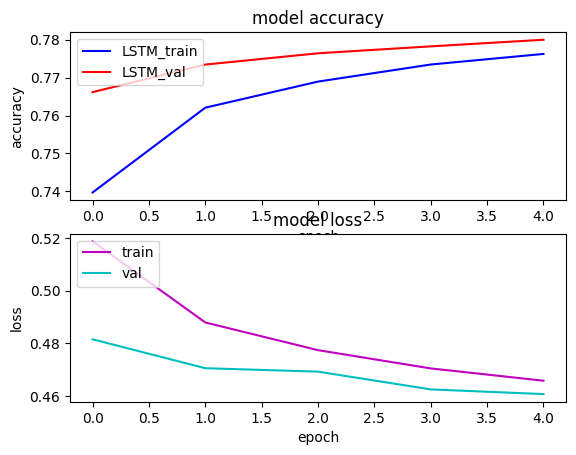

In [ ]:
s, (at, al) = plt.subplots(2,1)
# Plot training accuracy and validation accuracy on the first subplot (at)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

# Plot training loss and validation loss on the second subplot (al)
al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
# Function to decode sentiment based on a given score
def decode_sentiment(score):
  #If the score is greater than 0.5, it is considered positive;otherwise, it is negative.
    return "Positive" if score>0.5 else "Negative"

# Predict sentiment scores for test data using the model
scores = model.predict(x_test, verbose=1, batch_size=10000)
#Decode sentiment scores into 'Positive' or 'Negative' labels
#The variable y_pred_1d now contains the predicted sentiment labels for the test data.
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 102s 3s/step


### Confusion Matrix


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#cm (numpy.ndarray): Confusion matrix to be plotted.
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):

    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.



     # Normalize the confusion matrix
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

     # Plotting the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    # Display the normalized values inside the matrix
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

     # Set labels for axes
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

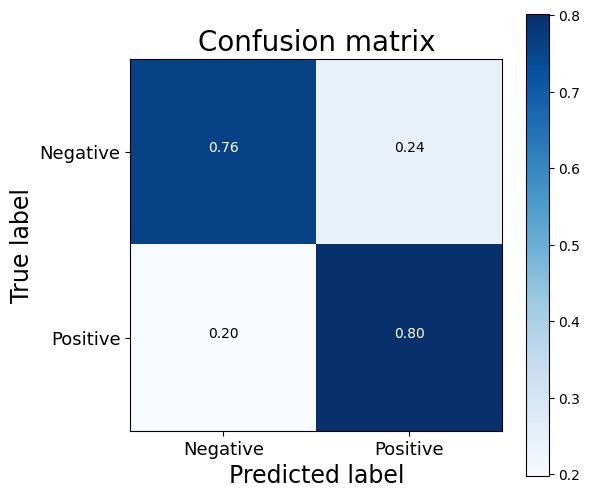

In [ ]:
# Assuming `y_pred_1d` and `test_data.sentiment` are defined elsewhere in your code
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
# Create a figure for the confusion matrix plot
plt.figure(figsize=(6,6))

plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [ ]:
# Print classification report
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.76      0.78    160542
    Positive       0.77      0.80      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

